# Project 1, Part 5, Best Customer Analytics

University of California, Berkeley
Master of Information and Data Science (MIDS) program
w205 - Fundamentals of Data Engineering

Student: Landon Morin

Year: 2022

Semester: Spring

Section:


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from calendar import day_name



import psycopg2

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [2]:
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [3]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [4]:
cursor = connection.cursor()

## The executives want you to come up with a high level design of a model, in the form of written criteria, to determine who the best customers are. 

## You do NOT have to code the model. 

## You do NOT have to give an actual list of best customers. 

## Create an executive summary explaining your model. You must support your summary with data, in the form of output of queries, data visualization, etc. There is a 1 query minimum.

In [5]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select c.customer_id as customer, 
       c.distance as distance_from_store, 
       s.city as store,
       count(distinct(sa.sale_id, sa.store_id)) as total_visits, 
       sum(l.quantity) as total_meals,
       sum(sa.total_amount) as total_sales
from stores as s
    left join customers as c
        on c.closest_store_id = s.store_id
    left join sales as sa
        on c.customer_id = sa.customer_id
    left join line_items as l
        on l.sale_id = sa.sale_id
group by c.customer_id, s.city
order by total_sales

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,customer,distance_from_store,store,total_visits,total_meals,total_sales
0,1528,3,Berkeley,16,273,7536
1,105,1,Berkeley,17,234,7932
2,6485,12,Berkeley,9,191,8256
3,12861,9,Seattle,14,278,9240
4,1757,3,Berkeley,17,340,9432
...,...,...,...,...,...,...
31077,7600,15,Berkeley,1,<NA>,<NA>
31078,2378,4,Berkeley,1,<NA>,<NA>
31079,10900,6,Seattle,1,<NA>,<NA>
31080,5366,9,Berkeley,1,<NA>,<NA>


In [48]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select c.customer_id as customer, 
       c.distance as distance_from_store, 
       s.city as store,
       count(distinct(sa.sale_id, sa.store_id)) as total_visits, 
       sum(sa.total_amount) as total_sales, 
       z.density as density, 
       z.population as population
from stores as s
    left join customers as c
        on c.closest_store_id = s.store_id
    left join zip_codes as z
        on c.zip = z.zip
    left join sales as sa
        on c.customer_id = sa.customer_id
group by c.customer_id, s.city, z.zip
order by total_sales

"""

df2 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df2

,customer,distance_from_store,store,total_visits,total_sales,density,population
0,6485,12,Berkeley,9,612,23198.27,44239
1,22530,3,Miami,14,648,8756.24,33464
2,12861,9,Seattle,14,672,3358.96,21619
3,1528,3,Berkeley,16,684,13421.84,31496
4,15264,22,Seattle,12,708,3024.07,21012
...,...,...,...,...,...,...,...
31077,19556,9,Dallas,1,<NA>,1007.25,30682
31078,11113,6,Seattle,1,<NA>,8138.00,35111
31079,11471,7,Seattle,1,<NA>,2357.41,18765
31080,10999,6,Seattle,1,<NA>,8138.00,35111


In [6]:
df = df.fillna(0)
df.store = pd.Categorical(df.store)


In [161]:
df['total_sales'] = df['total_sales'].astype(float)
df['total_visits'] = df['total_visits'].astype(float)

In [170]:
cities = df['store'].unique()
colors = sns.color_palette("flare")
x = list(df['total_visits'].values)
y = list(df['total_sales'].values)

Text(0.5, 1.0, 'Total Sales v. Total Visits')

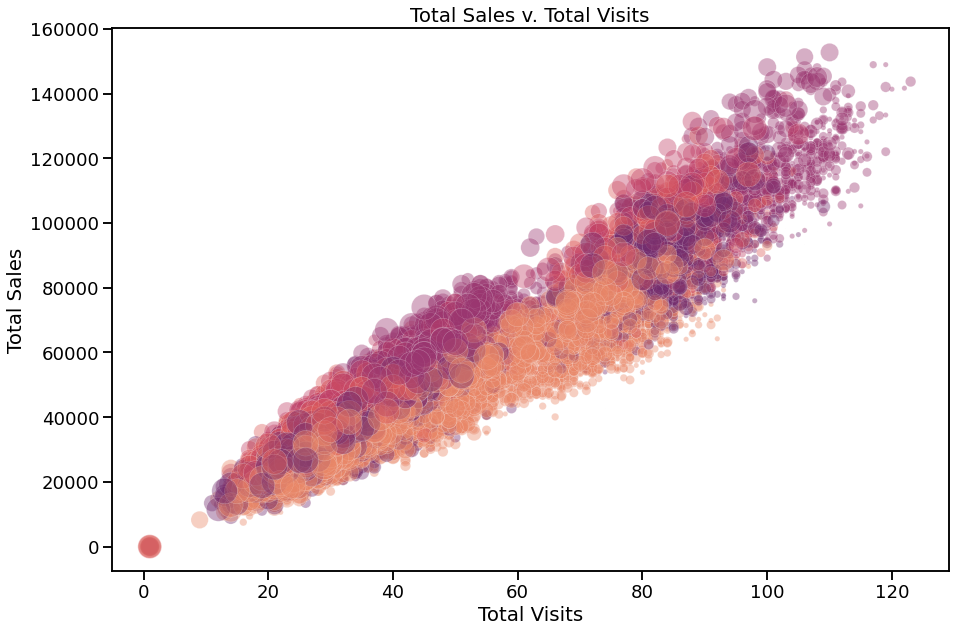

In [187]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.scatterplot(data=df, x=x, 
                y=y, size='distance_from_store', 
                hue = 'store',
                palette='flare',
                sizes=(minsize, maxsize), 
                alpha = .4, ax=ax, legend = False)



# Add titles (main and on axis)
plt.xlabel("Total Visits")
plt.ylabel("Total Sales")
plt.title("Total Sales v. Total Visits")



In [36]:
min_value = df['distance_from_store'].min()
max_value = df['distance_from_store'].max()

bins = np.linspace(min_value,max_value,5)

labels = ['1-6 Miles', '7-12 Miles', '13-18 Miles', '19-25 Miles']
df['bins'] = pd.cut(df['distance_from_store'], bins=bins, labels=labels, include_lowest=True)


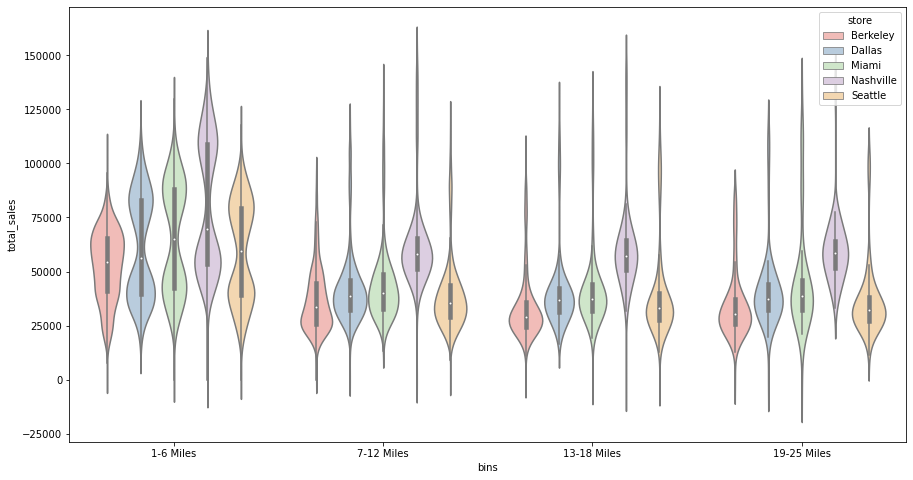

In [43]:
plt.figure(figsize = (15,8))
sns.violinplot(x="bins", y="total_sales", hue="store", data=df, palette="Pastel1")
plt.show()


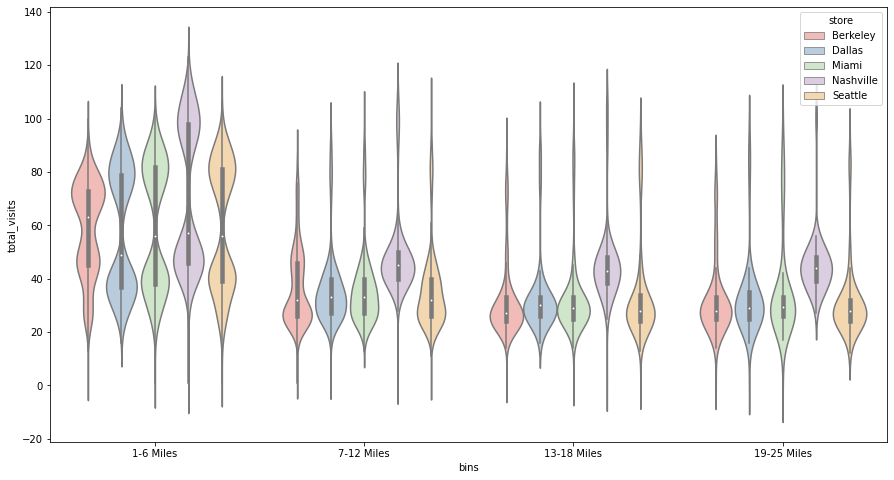

In [44]:
plt.figure(figsize = (15,8))
sns.violinplot(x="bins", y="total_visits", hue="store", data=df, palette="Pastel1")
plt.show()


In [58]:
min_value2 = df2['density'].min()
max_value2 = df2['density'].max()

bins2 = np.linspace(min_value2,max_value2,10)

labels2 = ['~<5.6k', '~5.6k-11k', '~11k-17k', '~17k-23k', '~23k-28k', '~28k-34k', '~34k-40k', '~40k-45k', '~45k-51k']
df2['bins'] = pd.cut(df2['density'], bins=bins2, labels=labels2, include_lowest=True)

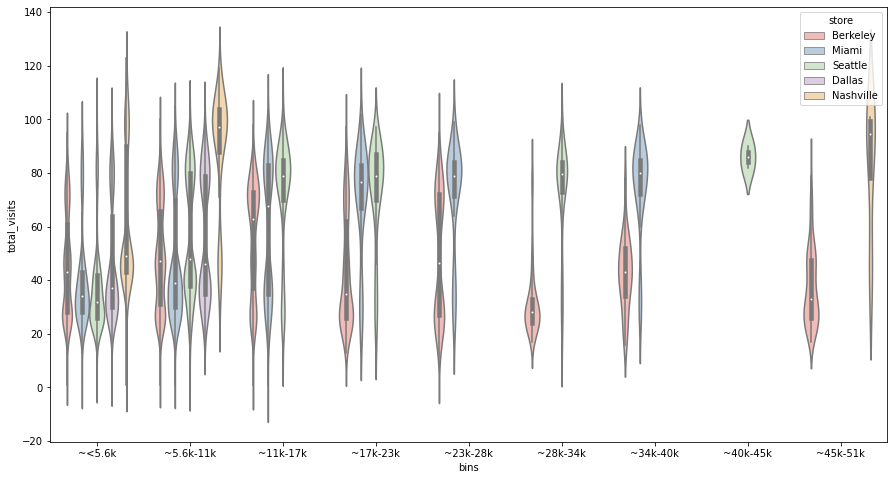

In [63]:
plt.figure(figsize = (15,8))
sns.violinplot(x="bins", y="total_visits", hue="store", data=df2, palette="Pastel1")
plt.show()

Text(0.5, 1.0, 'Total Sales v. Total Visits')

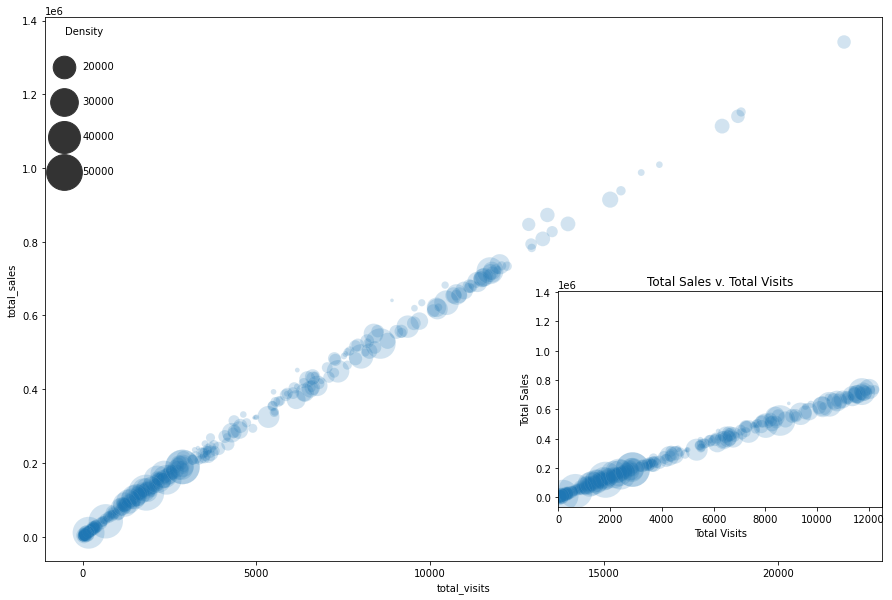

In [140]:
df_dense = df2.groupby('density').sum()
df_dense = df_dense.reset_index()

minsize = min(df_dense['density'])**2/2000000
maxsize = max(df_dense['density'])**2/2000000
fig, ax = plt.subplots(figsize=(15, 10))

sns.scatterplot(data=df_dense, x='total_visits', 
                y='total_sales', size='density', sizes=(minsize, maxsize), 
                alpha = .2, ax=ax)

ax2 = plt.axes([0.6, 0.2, .3, .3])
sns.scatterplot(data=df_dense, x='total_visits', 
                y='total_sales', size='density', sizes=(minsize, maxsize), 
                alpha = .2, ax=ax2, legend = False)
ax2.set_title('zoom')
ax2.set_xlim([0,12500])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper left', frameon = False, 
         labelspacing = 2.5, title = 'Density')

# Add titles (main and on axis)
plt.xlabel("Total Visits")
plt.ylabel("Total Sales")
plt.title("Total Sales v. Total Visits")



Text(0.5, 1.0, 'Total Sales v. Total Visits')

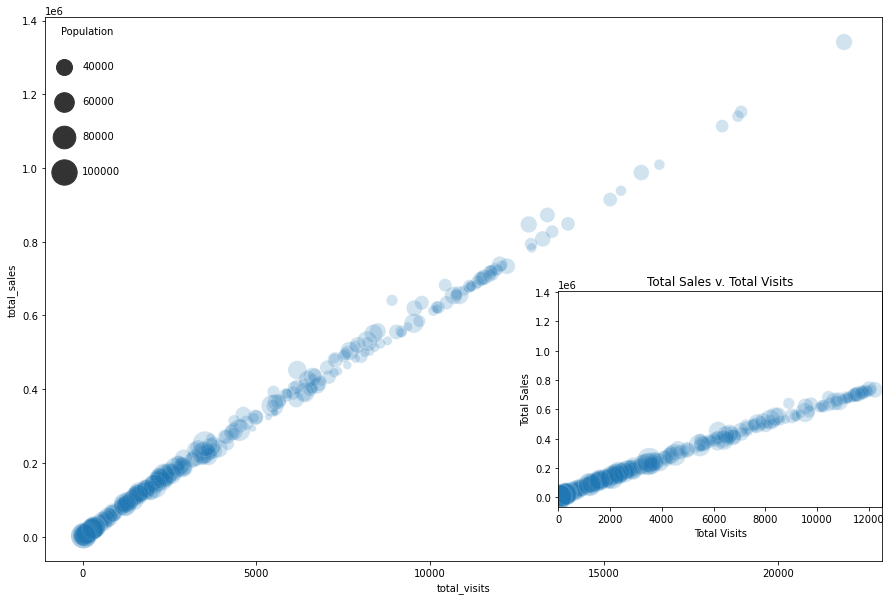

In [154]:
df_pop = df2.groupby('population').sum()
df_pop = df_pop.reset_index()

minsize = min(df_pop['population'])**1.5/50000
maxsize = max(df_pop['population'])**1.5/50000
fig, ax = plt.subplots(figsize=(15, 10))

sns.scatterplot(data=df_pop, x='total_visits', 
                y='total_sales', size='population', sizes=(minsize, maxsize), 
                alpha = .2, ax=ax)

ax2 = plt.axes([0.6, 0.2, .3, .3])
sns.scatterplot(data=df_pop, x='total_visits', 
                y='total_sales', size='population', sizes=(minsize, maxsize), 
                alpha = .2, ax=ax2, legend = False)
ax2.set_title('zoom')
ax2.set_xlim([0,12500])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper left', frameon = False, 
         labelspacing = 2.5, title = 'Population',)

# Add titles (main and on axis)
plt.xlabel("Total Visits")
plt.ylabel("Total Sales")
plt.title("Total Sales v. Total Visits")
